<a href="https://colab.research.google.com/github/madhavamk/computational-data-science/blob/master/MiniProjects/M8_NB_MiniProject_3_BitCoin_Forecasting_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPCI Upskilling - Data Science and Engineering Track

## A program by IIITH and TalentSprint

### Playground Challenge 4: BitCoin_Forecasting_ARMA [20 points]


##<b><font color="red">Please run this solution notebook on your Google Colab T4 GPU runtime</font></b>

To select the T4 GPU, follow these steps:

Runtime >> Change runtime type >> T4 GPU >> save

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARMA model and forecast the bit coin price

## Dataset



Bitcoin is a digital currency created in January 2009. It follows the ideas set out in a whitepaper by the mysterious and pseudonymous Satoshi Nakamoto. The identity of the person or persons who created the technology is still a mystery. Bitcoin offers the promise of lower transaction fees than traditional online payment mechanisms and, unlike government-issued currencies, it is operated by a decentralized authority.

Data Description
This dataset provides the history of daily prices of Bitcoin. The data starts from 17-Sep-2014 and is updated till 09-July-2021. All the column descriptions are provided below.

* Date: Day/Month/Year
* Open: Price from the first transaction of a trading day
* High: Maximum price in a trading day
* Low: Minimum price in a trading day
* Close: Price from the last transaction of a trading day
* Adj Close: Closing price adjusted to reflect the value after accounting for any corporate actions
* Volume: Number of units traded in a day

## Problem Statement

Perform EDA and forecast the Bitcoin price using ARMA model on timeseries (bitcoin) data.

## Grading = 20 Points

In [ ]:
#@title Download Dataset
!wget -qq !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/BTC.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import itertools

### Load the data and perform EDA [4 points]

Hint: Refer to this ['Bitcoin dataset EDA'](https://cdn.iisc.talentsprint.com/CDS/Assignments/Module6/M6_SNB_MiniProject_3_BitCoin_Forecasting_ARMA_Exploratory%20Data%20Analysis.pdf)

In [ ]:
# YOUR CODE HERE
df = pd.read_csv('BTC.csv')
df.head()

# EDA
# Identify null values
df.isnull().sum()
# Handle null values
df.dropna(inplace=True)
# Check for duplicate values
df.duplicated().sum()
# Handle duplicate values
df.drop_duplicates(inplace=True)

df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,8367.993124,8609.046940,8104.681274,8384.849217,8384.849217,1.314307e+10
std,12379.802902,12769.294273,11929.803665,12399.075891,12399.075891,1.979067e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,569.089508,575.391754,561.964737,569.758758,569.758758,7.095970e+07
50%,4947.056884,5115.198242,4829.396973,4971.905029,4971.905029,4.249775e+09
75%,9386.981445,9557.482911,9238.094238,9393.408692,9393.408692,2.026569e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


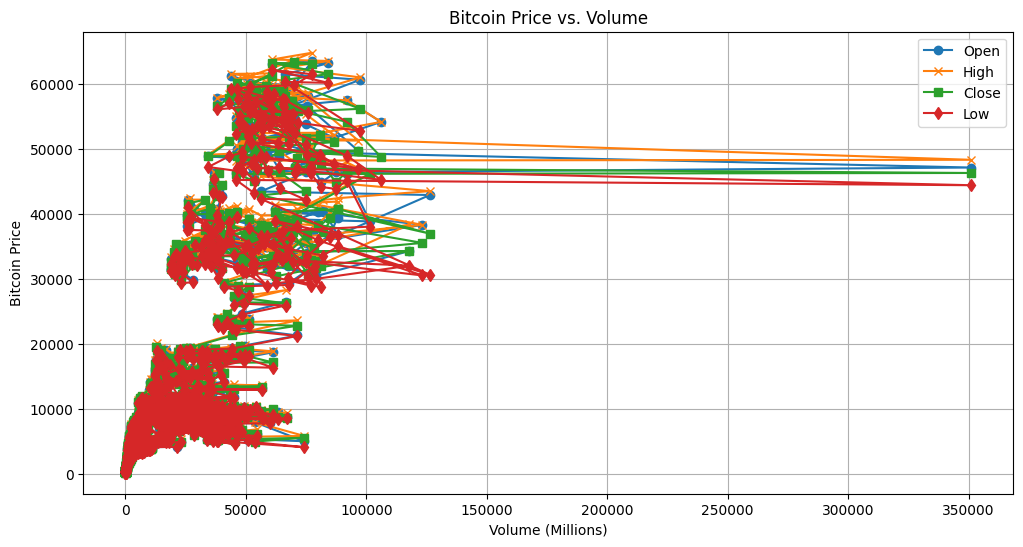

In [ ]:
import matplotlib.pyplot as plt


# Convert volume to millions (or any other suitable scale)
df['Volume_Millions'] = df['Volume'] / 1000000  # Divide by 1 million

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

plt.plot(df['Volume_Millions'], df['Open'], label='Open', marker='o')
plt.plot(df['Volume_Millions'], df['High'], label='High', marker='x')
plt.plot(df['Volume_Millions'], df['Close'], label='Close', marker='s')
plt.plot(df['Volume_Millions'], df['Low'], label='Low', marker='d')

plt.xlabel('Volume (Millions)')  # Update x-axis label
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price vs. Volume')
plt.legend()
plt.grid(True)

plt.show()

In [10]:
df.dtypes

# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

#### Analyze the correlation (heatmap) of all the features

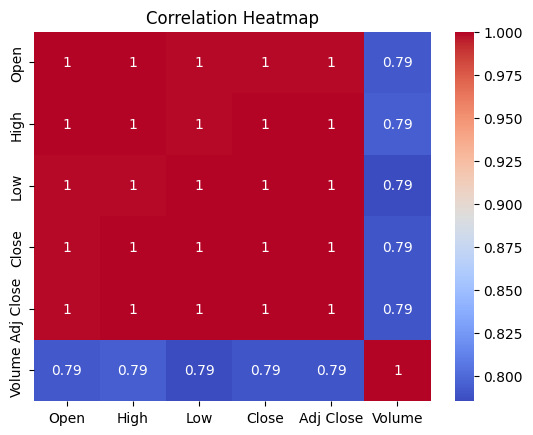

In [11]:
# YOUR CODE HERE
# Heatmap
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Interpretation of correlation
*   All price features seem to be highly correlated
*   Volume seem to be closely correlated to price
*   Since all values are highly correlated, we can keep one of them may be Close price for model training




### Test the Stationarity using Augmented Dicky Fuller Test [2 point]

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [13]:
# YOUR CODE HERE
result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.038593
p-value: 0.955222


*    Since p value > 0.05, there is high confidence not to reject null hypothesis, which indicates data is non-stationary

### Identify the trends and seasonality from the given time series data [4 points]

* Apply seasonal decompose and plot the results
* Check the stationarity of data using rolling mean and rolling standard deviation.
* Make the time series data stationary
  * Apply a log transformation to reduce the variance of the series
  * Eliminate the Trend and Seasonality by Differencing

**Note:** Ensure timeseries without NaN, inf, -inf values, Replace with 0 if found.

Read more about stationarity of a timeseries in the following [link](https://machinelearningmastery.com/time-series-data-stationary-python/)

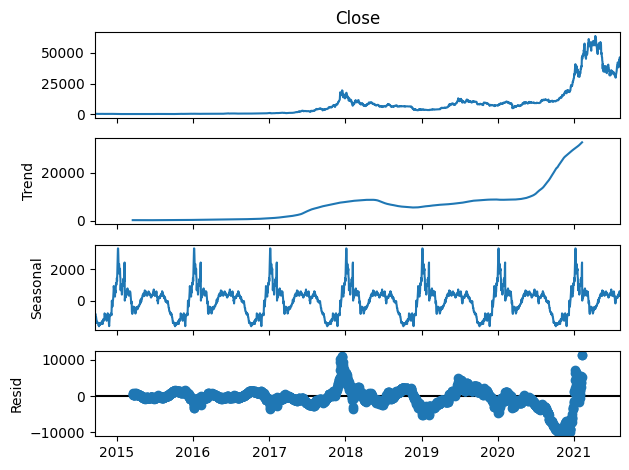

In [15]:
# YOUR CODE
result = seasonal_decompose(df['Close'], model='additive', period=365)
result.plot()
plt.show()

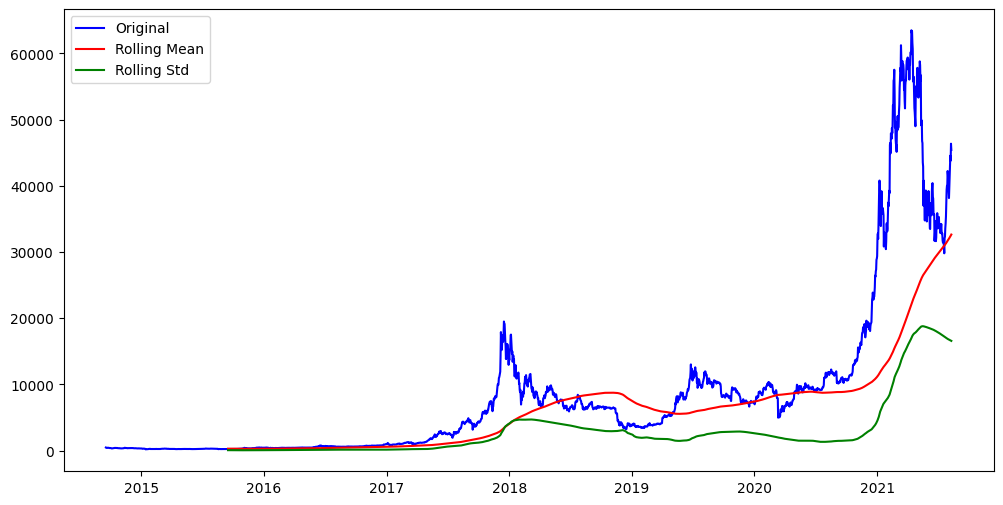

In [17]:
# Checking for stationarity using rolling mean and rolling std
rolling_mean = df['Close'].rolling(window=365).mean()
rolling_std = df['Close'].rolling(window=365).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.legend()
plt.show()

*   The graph for rolling mean and standard deviation does not seem to be constant. So, data is non-stationary.

In [20]:
# Make the time series data stationary
# Apply a log transformation to reduce the variance of the series
df['log_close'] = np.log(df['Close'])

# Eliminate the Trend and Seasonality by Differencing
df['diff_close'] = df['log_close'].diff()

# Replace inf/nan/-inf with 0
df.fillna(0, inplace=True)

### Test the Stationarity using Augmented Dicky Fuller Test [2 point]

Verify the stationarity post differencing, using ADF

Hint: [tsa.stattools.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [21]:
# YOUR CODE HERE
result = adfuller(df['diff_close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -15.049011
p-value: 0.000000


*   Since p value is < 0.05, null hypothesis can be rejected, and the data is stationary post first order difference

### Auto Correlation Plot [2 point]

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time.

* Plot the auto correlation function (ACF and PACF)
* Analyse ACF and PACF plots and define AR (p) and MA(q) terms

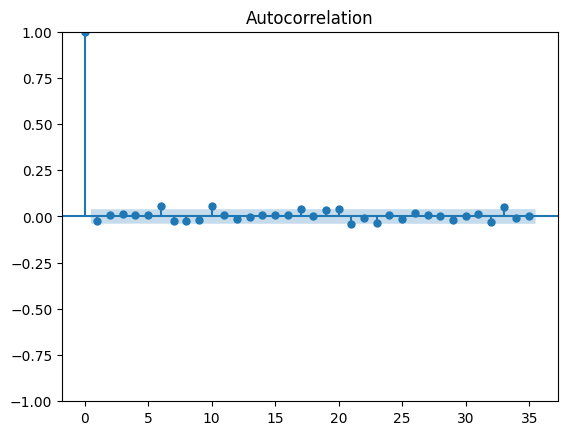

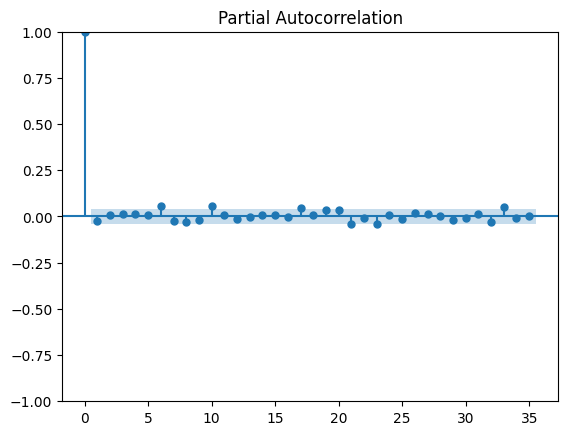

In [22]:
# YOUR CODE HERE
plot_acf(df['diff_close'])
plt.show()

plot_pacf(df['diff_close'])
plt.show()

*    Since the graph shows values in confidence interval at 1, p,q can be 1

### Train the Auto Regressive model [2 point]

Hint: sm.tsa.AR()

In [29]:
# YOUR CODE HERE
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df['diff_close'],2).fit()
model.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             diff_close   No. Observations:                 2516
Model:                     AutoReg(2)   Log Likelihood                4555.102
Method:               Conditional MLE   S.D. of innovations              0.040
Date:                Wed, 05 Mar 2025   AIC                          -9102.204
Time:                        18:29:14   BIC                          -9078.886
Sample:                             2   HQIC                         -9093.741
                                 2516                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.001      2.385      0.017       0.000       0.003
diff_close.L1    -0.0227      0.020     -1.140      0.254      -0.062       0.016
diff_close.L2     0.0091      0.020      0.458      0.647      -0.030       0.048
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.2932           +0.0000j            9.2932            0.5000
AR.2           11.7814           +0.0000j           11.7814            0.0000
-----------------------------------------------------------------------------
"""

### ARMA Model [2 point]

* Train the ARMA model on timeseries data and print AIC value

In [31]:
# YOUR CODE HERE for ARIMA Model
model = sm.tsa.ARIMA(df['diff_close'], order=(1, 0, 1))
results = model.fit()
print(results.summary())
print("AIC value:",results.aic)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             diff_close   No. Observations:                 2516
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4557.788
Date:                Wed, 05 Mar 2025   AIC                          -9107.575
Time:                        18:32:28   BIC                          -9084.254
Sample:                             0   HQIC                         -9099.111
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.287      0.022       0.000       0.003
ar.L1         -0.1473      0.643     -0.229      0.819      -1.407       1.113
ma.L1          0.1229      0.643      0.191      0.8

Since AIC value is less, it fits data well.

#### Plot the predictions for timeseries data [2 point]

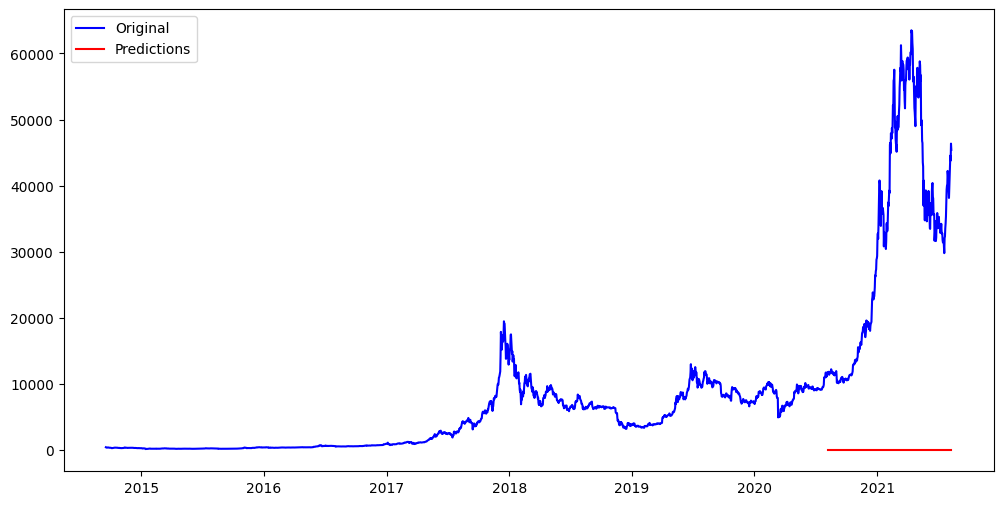

In [33]:
# YOUR CODE HERE
predictions = results.predict(start=len(df)-365, end=len(df)-1)
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Original', color='blue')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.show()

### Report Analysis

* Discuss how sudden effects of bitcoin price affects the model parameters
* State your observations about the trend and seasonality of the timeseries data
* Discuss how you selected ARMA (p and q) terms.
* Interpret the AIC value obtained for the ARMA model

* Bitcoin’s volatility affects ARMA model parameters, requiring frequent retraining.

* The time series has both trend and seasonality, requiring transformation and differencing.

* We selected ARMA(1,1) using ACF/PACF plots to capture dependencies.

* The AIC value (-9102) confirms a well-balanced model, but improvements can be made.